# Working with IBL atlas object

## Getting started

The Allen atlas image and annotation volumes can be accessed using the `iblatlas.atlas.AllenAtlas` class. Upon instantiating the class for the first time, the relevant files will be downloaded from the Allen database.

In [1]:
from iblatlas.atlas import AllenAtlas

res = 25 # resolution of Atlas, available resolutions are 10, 25 (default) and 50
brain_atlas = AllenAtlas(res_um=res)

## Exploring the volumes

The brain_atlas class contains two volumes, the dwi image volume and the annotation label volume

### 1. Image Volume 
Allen atlas dwi average template

Shape of image volume: (528, 456, 320)


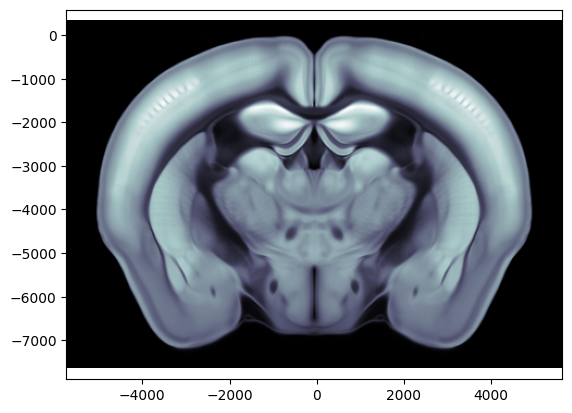

In [2]:
# Access the image volume
im = brain_atlas.image

# Explore the size of the image volume (ap, ml, dv)
print(f'Shape of image volume: {im.shape}')

# Plot a coronal slice at ap = -1000um
ap = -1000 / 1e6  # input must be in metres
ax = brain_atlas.plot_cslice(ap, volume='image')


### Label Volume


The label volume contains information about which brain region each voxel in the volume belongs to.

Shape of label volume: (528, 456, 320)


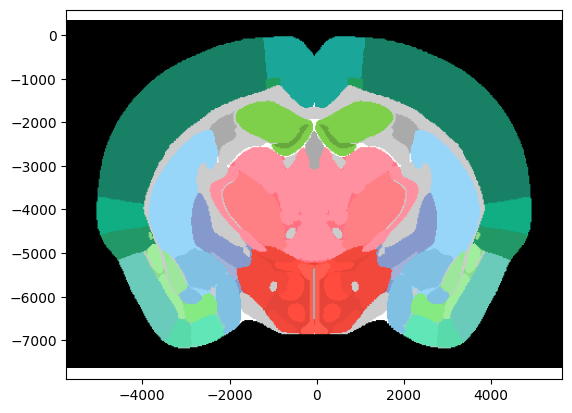

In [3]:
# Access the image volume
lab = brain_atlas.label

# Explore the size of the image volume (ap, ml, dv)
print(f'Shape of label volume: {lab.shape}')

# Plot a coronal slice at ap = -1000um
ap = -1000 / 1e6  # input must be in metres
ax = brain_atlas.plot_cslice(ap, volume='annotation')

The label volume used in the IBL AllenAtlas class differs from the Allen annotation volume in two ways.
- Each voxel has information about the index of the Allen region rather than the Allen atlas id
- The volume has been lateralised to differentiate between the left and right hemisphere

To understand this better let's explore the BrainRegions class that contains information about the Allen structure tree.

## Exploring brain regions

The Allen brain region structure tree can be accessed through the class `iblatlas.regions.BrainRegions`. 

In [4]:
from iblatlas.regions import BrainRegions

brain_regions = BrainRegions()

# Alternatively if you already have the AllenAtlas instantiated you can access it as an attribute
brain_regions = brain_atlas.regions

The brain_regions class has the following data attributes

In [5]:
brain_regions.__annotations__

{'id': numpy.ndarray,
 'name': object,
 'acronym': object,
 'rgb': numpy.uint8,
 'level': numpy.ndarray,
 'parent': numpy.ndarray,
 'order': numpy.uint16}

These attributes are the same as the Allen structure tree and for example `id` corresponds to the Allen atlas id while the `name` represents the full anatomical brain region name.

The index refers to the index in each of these attribute arrays. For example, index 1 corresponds to the `root` brain region with an atlas id of 977. 

In [6]:
index = 1
print(brain_regions.id[index])
print(brain_regions.acronym[index])

997
root


Alternatively, index 1000 corresponds to `PPYd` with an atlas id of 185

In [7]:
index = 1000
print(brain_regions.id[index])
print(brain_regions.acronym[index])

185
PPYd


In the label volume we described above, it is these indices that we are referring to. Therefore, we know all voxels in the volume with a value of 0 will be voxels that lie in `root`, while the voxels that have a value of 1000 will be in `PPYd`

In [8]:
import numpy as np
root_voxels = np.where(brain_atlas.label == 1)
ppyd_voxels = np.where(brain_atlas.label == 1000)

An additional nuance is the lateralisation. If you compare the size of the brain_regions data class to the Allen structure tree. You will see that it has double the number of columms. This is because the IBL brain regions encodes both the left and right hemisphere. We can understand this better by exploring the `brain_regions.id` and `brain_regions.name` at the indices where it transitions between hemispheres.

The `brain_region.id` go from positive Allen atlas ids (right hemisphere) to negative Allen atlas ids (left hemisphere)

In [9]:
print(brain_regions.id[1320:1340])

[        25         34         43         49         57         65
        624  304325711       -997         -8       -567       -688
       -695       -315       -184        -68       -667 -526157192
 -526157196 -526322264]


The `brain_region.name` go from right to left hemisphere descriptions

In [10]:
print(brain_regions.name[1320:1340])

['simple fissure' 'intercrural fissure' 'ansoparamedian fissure'
 'intraparafloccular fissure' 'paramedian sulcus' 'parafloccular sulcus'
 'Interpeduncular fossa' 'retina' 'root (left)'
 'Basic cell groups and regions (left)' 'Cerebrum (left)'
 'Cerebral cortex (left)' 'Cortical plate (left)' 'Isocortex (left)'
 'Frontal pole cerebral cortex (left)' 'Frontal pole layer 1 (left)'
 'Frontal pole layer 2/3 (left)' 'Frontal pole layer 5 (left)'
 'Frontal pole layer 6a (left)' 'Frontal pole layer 6b (left)']


In the label volume, we can therefore differentiate between left and right hemisphere voxels for the same brain region. First we will use a method in the brain_region class to find out the index of left and right `CA1`.

In [11]:
brain_regions.acronym2index('CA1')

(array(['CA1'], dtype=object), [array([ 458, 1785])])

The method `acronym2index` returns a tuple, with the first value being a list of acronyms passed in and the second value giving the indices in the array that correspond to the left and right hemispheres for this region. We can now use these indices to search in the label volume

In [12]:
CA1_right = np.where(brain_atlas.label == 458)
CA1_left = np.where(brain_atlas.label == 1785)

## Coordinate systems

The voxles can be translated to 3D space. In the IBL all xyz coordinates